In [1]:
import numpy as np
from numpy import linalg as LA
from util_tools.helper import *
import matplotlib.pyplot as plt
from util_tools.operators import *
from util_tools.update_funcs import *
#problem constants
var_dict = {}
nu_c=var_dict['nu_c']=1e-6
mu_c=var_dict['mu_c']=1e-3
rho_c=var_dict['rho_c']=1e+3
st_coef=0.06
#real timestep
dt=0.006
gradP=-2.4
from tqdm import tqdm
n_iter=0

#domain length
nx2=100
Lx1=0.04;Lx2=0.02;r_dpl=Lx2/4;M=3.0;u1_ave=0.0125;nx1=nx2*2;Nx1=nx1+1;Nx2=nx2+2
h=Lx1/nx1
var_dict = {'Lx1' : Lx1, 'Lx2' : Lx2, 'r_dpl': r_dpl,'h': h,'u1_ave':u1_ave,'Nx1':Nx1,'Nx2':Nx2,'M' : M,'nx1':nx1,'nx2':nx2,'dt':dt,'gradP':gradP,'st_coef':st_coef,'nu_c':nu_c,'mu_c':mu_c,'rho_c':rho_c}

#Initialization
un=np.zeros([Nx1,Nx2])
us=np.zeros([Nx1,Nx2])
unn=np.zeros([Nx1,Nx2])
u_ref=np.zeros([Nx1,Nx2])

vn=np.zeros([Nx1,Nx2])
vs=np.zeros([Nx1,Nx2])
vnn=np.zeros([Nx1,Nx2])

pn=np.zeros([nx1,nx2])
pnn=np.zeros([nx1,nx2])


rho=np.zeros([nx1,nx2])
mu=np.zeros([nx1,nx2])



phin=np.zeros( [nx1,nx2] )
phis=np.zeros([nx1,nx2])
phinn=np.zeros([nx1,nx2])

Tx1,Tx2=17,15

#half_index_grid
hig_x, hig_y = np.meshgrid(np.linspace(-Lx1/2, Lx1/2, num=Nx1),np.linspace(-Lx2/2, Lx2/2,Nx2),indexing='ij')
xi=np.round(inter_polator(hig_x,var_dict),4)
xj=np.round(inter_polator(hig_y,var_dict),4)

# #full_index_grid
#xi, xj = np.meshgrid(np.round(np.linspace(0+h/2, Lx1-h/2, num=nx1),4),np.round(np.linspace(0+h/2, Lx2-h/2,nx2),4),indexing='ij')

# #lvlset init
phin_int=lvlset_init(xi, xj,var_dict)
phin=phin_int.copy()

rho_int=rho_distr(phin,var_dict)
rho=rho_int.copy()

mu_int=mu_distr(phin,var_dict)
mu=mu_int.copy()

u=ref_vel_prof(hig_y[0])
for _ in range(Nx1):
    un[_,:]=u
#un[:]
u_inter=inter_polator(un,var_dict)
umax=np.max(u_inter)
CFL=umax*dt/h

In [ ]:
CFL

In [14]:
for _ in tqdm(range(1)):
    us=predictor(un,vn, mu, rho,var_dict)
    us=BC_looper(us)
    pn=projector( us, vs, pn,rho,var_dict)
    pn[0,:]=pn[-2,:]
    pn[-1,:]=pn[1,:]
    unn=corrector(us, pn, unn, rho,var_dict)
    unn=BC_looper(unn)

    L_phi_n,phis=phis_predictor(phin,un,vn,var_dict)

    phinn=phinn_corrector(L_phi_n,phin,phis,un,vn,var_dict)

    
    rho=rho_distr(phinn,var_dict)
    mu=mu_distr(phinn,var_dict)
    tr=np.where(unn==0,0.0001,unn)
    tr=np.where((tr<=1e5)&(tr>=-1e5),tr,False)
    if np.all(tr)==False:
        break
    tr=np.where(pnn==0,0.0001,pnn)
    tr=np.where((tr<=1e5)&(tr>=-1e5),tr,False)
    if np.all(tr)==False:
        break
    un=unn.copy()
    phin=phinn.copy()
    #var_dict['dt']=var_dict['dt']/5 
u=inter_polator(un,var_dict)

drop_elem = np.where(phin <0,np.min(phin),0)
drop_elem_int = np.where(phin_int<0,np.min(phin_int),0)

#phin[np.where(phin > 0)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


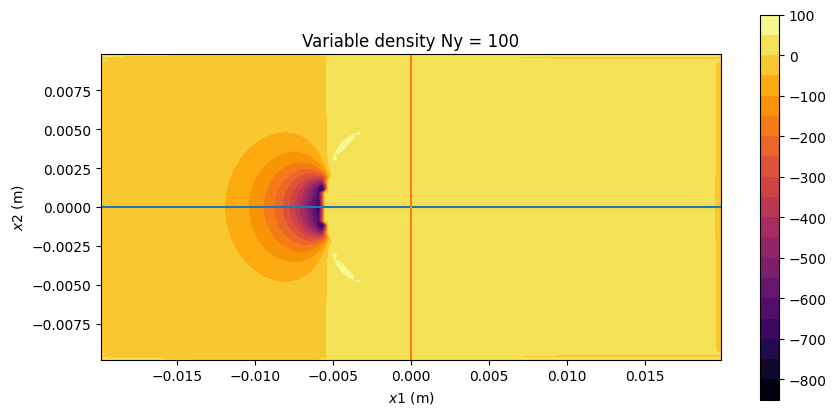

In [17]:
fig, ax=plt.subplots(figsize=(10, 5))
plt.plot([i for i in xi[:,0]],[0 for i in xi[:,0]])
plt.plot([0 for i in xj[0,:]],[i for i in xj[0,:]])
plt.contourf(xi, xj,u, 20, cmap='inferno')

#plt.contourf(xi, xj,u, 20, cmap='coolwarm')
#ax.add_patch(plt.Circle((0, 0), radius=r_dpl, color='black', fill=False))
plt.colorbar()
plt.xlabel('$x1$ (m)')
plt.ylabel('$x2$ (m)')
#plt.title('domain $u$ contour ($m/s$)')
plt.title(f"Variable density Ny = {nx2}")
plt.gca().set_aspect('equal')
plt.show()

In [ ]:

#plt.plot([0+ 50 for i in range(50)],[i for i in range(50)])

In [ ]:
xj[0,:]

In [ ]:
h/2

In [ ]:
Lx2

In [ ]:
for _ in tqdm(range(1)):
    us=predictor(un,vn, mu, rho,var_dict)
    us=BC_looper(us)
    res=1000
    while res>1e-3:
        pnn=projector( us, vs, pn,rho,var_dict)
        res1=res
        res=LA.norm(pnn-pn)
        if abs(res-res1)<1e-5:
            break
        pn=pnn.copy()
    unn=corrector(us, pnn, unn, rho,var_dict)
    unn=BC_looper(unn)

    L_phi_n,phis=phis_predictor(phin,un,vn,var_dict)

    phinn=phinn_corrector(L_phi_n,phin,phis,un,vn,var_dict)

    
    rho=rho_distr(phinn,var_dict)
    mu=mu_distr(phinn,var_dict)
    tr=np.where(unn==0,0.0001,unn)
    tr=np.where((tr<=1e5)&(tr>=-1e5),tr,False)
    if np.all(tr)==False:
        break
    tr=np.where(pnn==0,0.0001,pnn)
    tr=np.where((tr<=1e5)&(tr>=-1e5),tr,False)
    if np.all(tr)==False:
        break
    un=unn.copy()
    phin=phinn.copy()
    #var_dict['dt']=var_dict['dt']/5 
u=inter_polator(un,var_dict)

drop_elem = np.where(phin <0,np.min(phin),0)
drop_elem_int = np.where(phin_int<0,np.min(phin_int),0)

#phin[np.where(phin > 0)]

In [ ]:
np.sum(abs(phin-phin_int))

In [ ]:
fig, ax=plt.subplots(figsize=(10, 5))
plt.contourf(xi, xj,u, 20, cmap='inferno')
#ax.add_patch(plt.Circle((0, 0), radius=r_dpl, color='black', fill=False))
plt.colorbar()
plt.xlabel('$x1$ (m)')
plt.ylabel('$x2$ (m)')
#plt.title('domain $u$ contour ($m/s$)')
plt.title(f"Variable density Ny = {nx2}")
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
fig, ax=plt.subplots(figsize=(10, 5))
plt.contourf(xi, xj, phin, 20, cmap='inferno')
ax.add_patch(plt.Circle((0, 0), radius=r_dpl, color='black', fill=False))
plt.colorbar()
plt.xlabel('$x1$ (m)')
plt.ylabel('$x2$ (m)')
#plt.title('domain $u$ contour ($m/s$)')
plt.title(f"Variable density Ny = {nx2}")
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
ax = plt.figure(figsize=(20, 10)).add_subplot(projection='3d')
# Plot the 3D surface
ax.plot_surface(xi, xj, phinn, edgecolor='black')
#ax.contourf(xi, xj, phin, zdir='y', offset=0.004, cmap='coolwarm')
#ax.contourf(xi, xj, phin, zdir='z', cmap='coolwarm')
#ax.contourf(xi, xj, drop_elem, zdir='z', cmap='inferno')
#ax.contourf(xi, xj, phin, zdir='z',offset=np.max(phin-phin_int), cmap='coolwarm')
#ax.contourf(xi, xj, phi_diff, zdir='z', cmap='coolwarm')
#ax.contourf(xi, xj, phi_diff, zdir='y', cmap='coolwarm')
#ax.set(xlim=(-0.02, 0.02), ylim=(-0.01, 0.01),xlabel='X', ylabel='Y', zlabel='Z')

#ax.scatter(xi, xj, zs=drop_elem_int, zdir='z', c='g', label='points in (x, y)')
#ax.scatter(xi, xj, zs=drop_elem, zdir='z', c='r', label='points in (x, z)')
ax.set(xlim=(-0.02, 0.02), ylim=(-0.01, 0.01),xlabel='X', ylabel='Y', zlabel='Phi')
#ax.view_init(azim=0, roll=0)
ax.set_title('3d Surface Plot Initial Level Set')
plt.show()

In [ ]:
res=100
us=predictor(un,vn, mu, rho,var_dict)
us=BC_looper(us)
while res>0.5e-3:
    pnn=projector( us, vs, pn,rho,var_dict)
    res1=res
    res=LA.norm(pnn-pn)
    pn=pnn.copy()
unn=corrector(us, pnn, unn, rho,var_dict)

In [ ]:
fig, ax=plt.subplots()
plt.contourf(xi, xj, pnn, 2,cmap='coolwarm')
ax.add_patch(plt.Circle((0, 0), radius=r_dpl, color='yellow', fill=False))

plt.colorbar()
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.title('domain initial level-set, ', fontsize=9) 
plt.gca().set_aspect('equal') 

In [ ]:
fig, ax=plt.subplots()
plt.contourf(xi, xj, phin_int, 2,cmap='coolwarm')
ax.add_patch(plt.Circle((0, 0), radius=r_dpl, color='yellow', fill=False))

plt.colorbar()
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.title('domain initial level-set, ', fontsize=9) 
plt.gca().set_aspect('equal') 

In [ ]:
for _ in tqdm(range(6)):
    us=predictor(un,vn, mu, rho,var_dict)
    us=BC_looper(us)
    res=1000
    while res>0.5e-3:
        pnn=projector( us, vs, pn,rho,var_dict)
        res1=res
        res=LA.norm(pnn-pn)
        pn=pnn.copy()
    unn=corrector(us, pnn, unn, rho,var_dict)
    unn=BC_looper(unn)

    L_phi_n,phis=phis_predictor(phin,un,vn,var_dict)

    phinn=phinn_corrector(L_phi_n,phin,phis,un,vn,var_dict)

    
    rho=rho_distr(phin,var_dict)
    mu=mu_distr(phin,var_dict)
    tr=np.where(unn==0,0.0001,unn)
    tr=np.where((tr<=1e5)&(tr>=-1e5),tr,False)
    if np.all(tr)==False:
        break
    tr=np.where(pnn==0,0.0001,pnn)
    tr=np.where((tr<=1e5)&(tr>=-1e5),tr,False)
    if np.all(tr)==False:
        break
    un=unn.copy()
    phin=phinn.copy()
    #var_dict['dt']=var_dict['dt']/5 
u=inter_polator(un,var_dict)

drop_elem = np.where(phin <0,np.min(phin),0)
drop_elem_int = np.where(phin_int<0,np.min(phin_int),0)

#phin[np.where(phin > 0)]

In [ ]:
plt.imshow(rho.T)
plt.colorbar()

In [ ]:
np.allclose(rho,rho_int)

In [ ]:
fig, ax=plt.subplots()
plt.contourf(xi, xj, u, 20,cmap='coolwarm')
ax.add_patch(plt.Circle((0, 0), radius=r_dpl, color='yellow', fill=False))

plt.colorbar()
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.title('domain initial level-set, ', fontsize=9) 
plt.gca().set_aspect('equal') 

In [ ]:
fig, ax=plt.subplots()
plt.contourf(xi, xj, u_inter, 20,cmap='coolwarm')
ax.add_patch(plt.Circle((0, 0), radius=r_dpl, color='yellow', fill=False))

plt.colorbar()
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.title('domain initial level-set, ', fontsize=9) 
plt.gca().set_aspect('equal') 

In [ ]:
fig, ax=plt.subplots()
plt.contourf(xi, xj, rho_int, 2,cmap='coolwarm')
ax.add_patch(plt.Circle((0, 0), radius=r_dpl, color='yellow', fill=False))

plt.colorbar()
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.title('domain initial level-set, ', fontsize=9) 
plt.gca().set_aspect('equal') 

In [ ]:
fig, ax=plt.subplots()
plt.contourf(xi, xj, drop_elem_int, 3,cmap='coolwarm')
ax.add_patch(plt.Circle((0, 0), radius=r_dpl, color='yellow', fill=False))

plt.colorbar()
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.title('domain initial level-set, ', fontsize=9) 
plt.gca().set_aspect('equal') 

In [ ]:
fig, ax=plt.subplots()
plt.contourf(xi, xj, phin, 20, cmap='inferno')
ax.add_patch(plt.Circle((0, 0), radius=r_dpl, color='black', fill=False))
plt.colorbar()
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.title('domain $u$ contour ($m/s$)')
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
fig, ax=plt.subplots()
plt.contourf(xi, xj, phin_int, 20, cmap='inferno')
ax.add_patch(plt.Circle((0, 0), radius=r_dpl, color='black', fill=False))
plt.colorbar()
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.title('domain $u$ contour ($m/s$)')
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
plt.contourf(xi, xj, pn, 5, cmap='inferno')
plt.colorbar()
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.title('domain $u$ contour ($m/s$)')
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
drop_elem_int

In [ ]:
pos_dist=np.where(phin>0,phin,0)

In [ ]:
pos_dist

In [ ]:
cols=pd.DataFrame(phin.T).columns
new_cols=[]

In [ ]:
phin_df=pd.DataFrame(phin.T)

In [ ]:
type(cols[1])

In [ ]:
for _ in range(len(cols)):
    new_cols.append('col'+ str(cols[_]))

In [ ]:
dist=np.where(phin>0,np.max(phin),0)
dist_int=np.where(phin_int>0,np.max(phin_int),0)

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
# Plot the 3D surface
#ax.plot_surface(xi, xj, drop_elem, edgecolor='royalblue')
#ax.contourf(xi, xj, phin, zdir='y', offset=0.004, cmap='coolwarm')
#ax.contourf(xi, xj, phin, zdir='z', cmap='coolwarm')
#ax.contourf(xi, xj, drop_elem, zdir='z', cmap='inferno')
#ax.contourf(xi, xj, phin, zdir='z',offset=np.max(phin-phin_int), cmap='coolwarm')
#ax.contourf(xi, xj, phi_diff, zdir='z', cmap='coolwarm')
#ax.contourf(xi, xj, phi_diff, zdir='y', cmap='coolwarm')
#ax.set(xlim=(-0.02, 0.02), ylim=(-0.01, 0.01),xlabel='X', ylabel='Y', zlabel='Z')

ax.scatter(xi, xj, zs=drop_elem_int, zdir='z', c='g', label='points in (x, y)')
ax.scatter(xi, xj, zs=drop_elem, zdir='z', c='r', label='points in (x, z)')
ax.set(xlim=(-0.02, 0.02), ylim=(-0.01, 0.01),xlabel='X', ylabel='Y', zlabel='Z')
plt.show()

In [ ]:
((rho[1:-1,1:-1]/(dt))@(us[2:-1,2:-2]-us[1:-2,2:-2]).T).shape

In [ ]:
(rho[1:-1,1:-1]/(dt)).shape

In [ ]:
(us[2:-1,2:-2]-us[1:-2,2:-2]).shape